# LinkedIn ML & AI Analytics Pipeline

## Step 1: Environment Setup

In [1]:
# Import necessary libraries
import os
import time
import json
import weaviate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from weaviate.auth import AuthApiKey
from pyspark.sql import SparkSession
from pyspark.sql import functions as pf
from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import silhouette_score
from pyspark.sql.functions import col, lower

/Users/prathikpradeep/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/prathikpradeep/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
# Load file with environment variables
_ = load_dotenv(find_dotenv("Requirements.env")) # read local .env file

In [18]:
# Initialize Spark session
def create_spark_session():
    # Update the path to the actual JAR file location
    jar_path = "/Users/prathikpradeep/spark-connector/target/scala-2.12/spark-connector-assembly-1.2.8-SNAPSHOT.jar"
    print(f"Including JAR: {jar_path}")

    # Initialize Spark session
    spark = (
        SparkSession.builder.config(
            "spark.jars",
            jar_path,
        )
        .master("local[*]")
        .appName("weaviate")
        .getOrCreate()
    )

    spark.sparkContext.setLogLevel("WARN")

    print("Spark Session Created")
    print("Included JARs:", spark.sparkContext._conf.get("spark.jars"))
    return spark

spark = create_spark_session()

Including JAR: /Users/prathikpradeep/spark-connector/target/scala-2.12/spark-connector-assembly-1.2.8-SNAPSHOT.jar
Spark Session Created
Included JARs: /Users/prathikpradeep/spark-connector/target/scala-2.12/spark-connector-assembly-1.2.8-SNAPSHOT.jar


In [3]:
# Initialize Weaviate client
def weaviate_connect():
    # Create a client to connect to the Docker container running on port 8080
    client = weaviate.Client(
        url="http://localhost:8080",
        auth_client_secret=AuthApiKey(api_key=os.getenv('WEAVIATE_API_KEY')),
        additional_headers={
            "X-OpenAI-Api-Key": os.getenv('OPENAI_API_KEY')
        }
    )

    # Check if the client is ready
    if client.is_ready():
        print("Client is ready to use.")
    else:
        print("Client is not ready.")

    client.is_ready()
    
    return client

client = weaviate_connect()

/Users/prathikpradeep/opt/anaconda3/lib/python3.9/site-packages/weaviate/warnings.py:162: DeprecationWarning: Dep016: Python client v3 `weaviate.Client(...)` connections and methods are deprecated. Update
            your code to use Python client v4 `weaviate.WeaviateClient` connections and methods.

            For Python Client v4 usage, see: https://weaviate.io/developers/weaviate/client-libraries/python
            For code migration, see: https://weaviate.io/developers/weaviate/client-libraries/python/v3_v4_migration
            
  warnings.warn(


Client is ready to use.


## Step 2: Data Loading

In [28]:
# Load job postings data
def load_data(spark, file_path):
    return spark.read.csv(file_path, header=True, inferSchema=True, multiLine=True)

df = load_data(spark, "postings.csv")

## Step 3: Data Preprocessing

In [30]:
# Select relevant columns
def select_relevant_columns(df):
    selected_columns = ["job_id", "company_name", "title", "description"]
    return df.select(selected_columns)

job_postings = select_relevant_columns(df)

In [31]:
# Filter job postings related to ML/AI
def filter_ml_ai_jobs(df):
    keywords = ["machine learning", "artificial intelligence", "AI", "ML", "data science"]
    return df.filter(
        lower(col("title")).rlike('|'.join([f'.*{keyword}.*' for keyword in keywords])) |
        lower(col("description")).rlike('|'.join([f'.*{keyword}.*' for keyword in keywords]))
)

filtered_df = filter_ml_ai_jobs(job_postings)

## Step 4: Data Ingestion to Weaviate

In [22]:
# Create schema in Weaviate
def create_weaviate_schema(client):
    # Setting/resetting the schema. CAUTION: This will delete the collection 
    if client.schema.exists("JobPostings1"):
        client.schema.delete_class("JobPostings1")

    client.schema.create_class(
        {
            "class": "JobPostings1",
            "properties": [
                {"name": "job_id", "dataType": ["string"]},
                {"name": "company_name", "dataType": ["string"]},
                {"name": "title", "dataType": ["string"]},
                {"name": "description", "dataType": ["string"]},
                ],
            "vectorizer": "text2vec-openai",
            "moduleConfig": {
            "text2vec-openai": {
              "model": "text-embedding-3-small",
              "dimensions": 1536,
              "type": "text"
            },
        }
    })


create_weaviate_schema(client)

In [50]:
# Write to Weaviate
def write_to_weaviate(df, class_name="JobPostings1"):
    df.write.format("io.weaviate.spark.Weaviate") \
            .option("batchSize", 1) \
            .option("timeout", 2) \
            .option("scheme", "http") \
            .option("host", "localhost:8080") \
            .option("header:X-OpenAI-Api-Key", os.getenv("OPENAI_API_KEY")) \
            .option("className", class_name) \
            .option("oidc:username", os.getenv("WEAVIATE_USERNAME")) \
            .option("oidc:password", os.getenv("WEAVIATE_PASSWORD")) \
            .mode("append").save()

write_to_weaviate(filtered_df)

## Step 5: Clustering

In [4]:
# Retrieve embeddings from Weaviate for clustering
def retrieve_embeddings(client):
    query = """
    {
      Get {
        JobPostings1 {
          job_id
          company_name
          title
          description
          _additional {
            vector
          }
        }
      }
    }
    """
    response = client.query.raw(query)
    results = response['data']['Get']['JobPostings1']
    return pd.DataFrame(results)

results_df = retrieve_embeddings(client)
embeddings = results_df['_additional'].apply(lambda x: x['vector']).tolist()

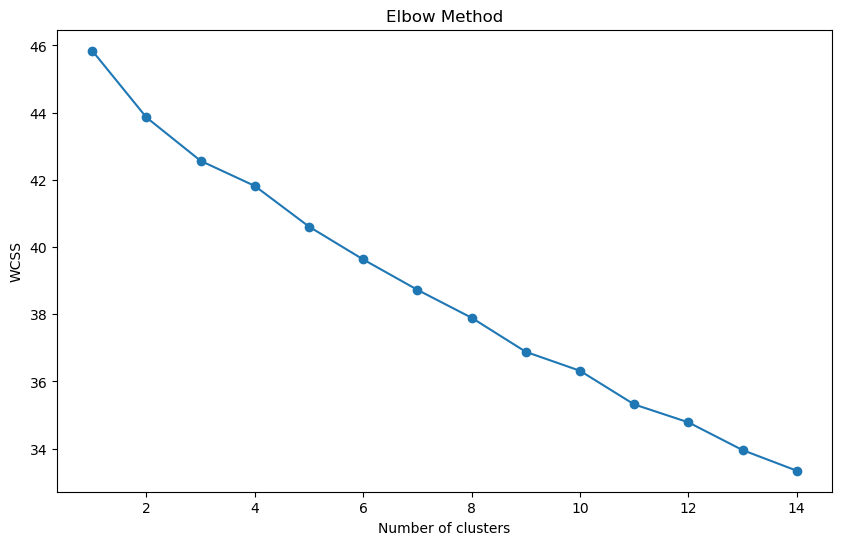

In [5]:
# Elbow Method to find optimal number of clusters
def elbow_method_line(embeddings):
    wcss = []
    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 15), wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

elbow_method_line(embeddings)

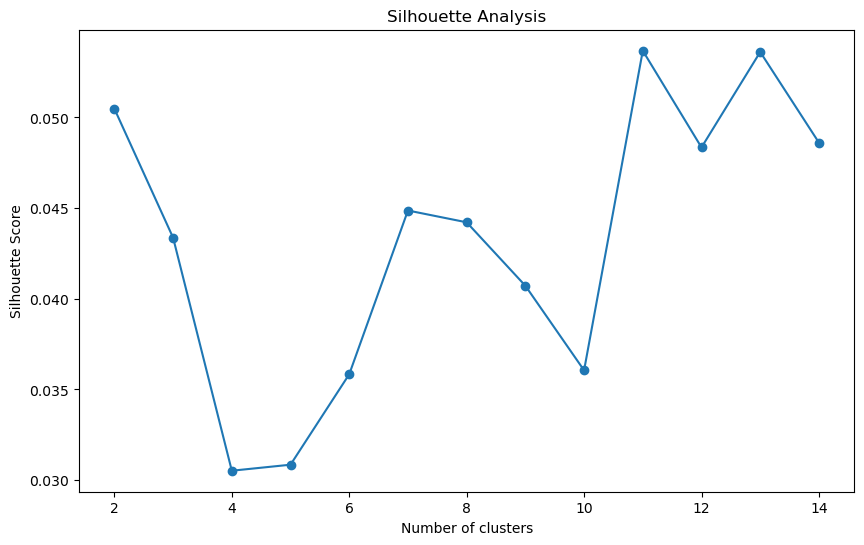

In [6]:
# Silhouette Analysis to find optimal number of clusters
def silhouette_analysis_line(embeddings, ):
    silhouette_scores = []
    for n_clusters in range(2, 15):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 15), silhouette_scores, marker='o')
    plt.title('Silhouette Analysis')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

silhouette_analysis_line(embeddings)

In [7]:
# Apply KMeans clustering with optimal number of clusters
def apply_clustering(embeddings, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(embeddings), kmeans

results_df['cluster'], kmeans = apply_clustering(embeddings)

## Step 6: Analysis and Visualization

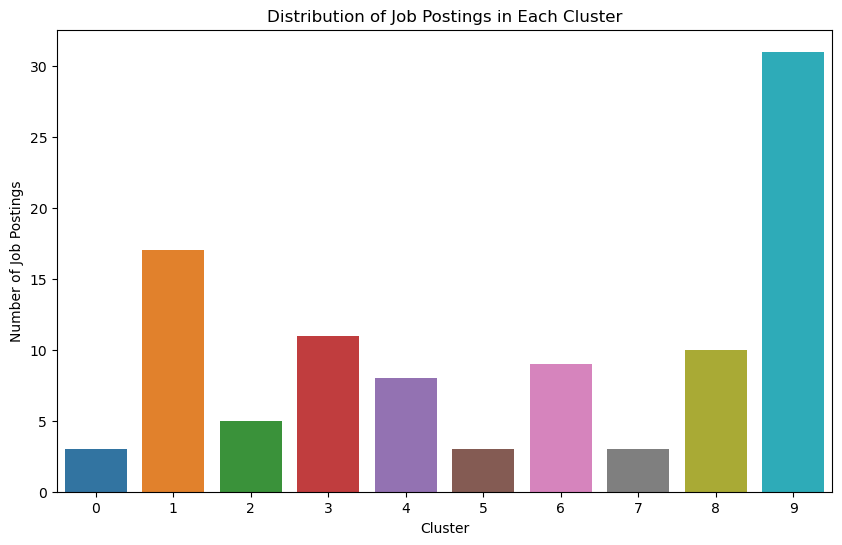

In [8]:
# Count of job postings in each cluster
def plot_cluster_distribution(results_df):
    cluster_counts = results_df['cluster'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
    plt.xlabel("Cluster")
    plt.ylabel("Number of Job Postings")
    plt.title("Distribution of Job Postings in Each Cluster")
    plt.show()

plot_cluster_distribution(results_df)

In [9]:
# Display a few job postings from each cluster
def display_cluster_samples(results_df, kmeans):
    for cluster in range(kmeans.n_clusters):
        print(f"\nCluster {cluster}:")
        display(results_df[results_df['cluster'] == cluster][['title', 'description']].head(10))

display_cluster_samples(results_df, kmeans)


Cluster 0:


,title,description
35,"Senior Manager, DSP Inventory Partnerships",Who We Are\n\nZeta Global (NYSE: ZETA) is the ...
42,A.I. Enhanced Partner Success Manager,WHO WE ARE Zeta Global (NYSE: ZETA) is the Dat...
50,Senior Account Manager - Programmatic,"""WHO WE ARE Zeta Global (NYSE: ZETA) is the Da..."



Cluster 1:


,title,description
6,Sales Enablement Specialist,"Sales Enablement Specialist Location: Atlanta,..."
21,Back End Developer,Company DescriptionRising Tide is a First Prin...
26,Data Scientist with BERT and Genomics Experience,We need a Data Scientist with demonstrated exp...
29,"Director, Digital Health Implementation, Evinova",Are you ready to be part of the future of heal...
30,Senior Software Engineer / Manager - Full Stac...,Who We Are\nAmberBox is the industry leader in...
32,UX/UI Designer,Company DescriptionMIDIScale is a company that...
38,"QA Engineer - Remote, Contract ($55/hr)","OKLabs has partnered with RemoTasks, a Scale A..."
46,Senior Lead Software Engineer,Position Summary:At NAVEX you will join our pr...
52,Optical Engineer,Job ResponsibilitiesServe as a laser and optic...
57,"AI Engineer, Biologics Engineering, Oncology R&D",In this role you form part of a Bioinformatics...



Cluster 2:


,title,description
2,ISSO GRC Risk Management Intelligence Lead,We are creating an operationally effective and...
3,Business Engineer,Business Engineering is looking for impact-foc...
13,"Senior Director, Trust & Safety Enforcement Op...",Company Description\n\nEtsy is the global mark...
47,Central Investigations Analyst,The Central Investigations team is dedicated t...
93,"Executive Mixed Reality Producer, Entertainmen...",Meta’s Reality Labs’ Entertainment Content tea...



Cluster 3:


,title,description
14,Analytics Engineer,"A pioneer in K–12 education since 2000, Amplif..."
28,"Sr. Staff Engineer, GPU Performance Modeling","Position Summary\n\nSamsung, a world leader in..."
36,Graduate Internship - (MS/PhD),Job Description\n\nIn the hardware development...
49,"Staff Software Engineer, Google Cloud Platforms",Minimum qualifications:\n\nBachelor's degree o...
51,"Senior Staff Software Engineer, Google Cloud, ...",Note: By applying to this position you will ha...
55,"Software Development Engineer, Amazon Visual E...",Description\n\nThe Amazon Visual Experience (A...
61,"Director, Talent Development",Gong transforms revenue organizations by harne...
68,"Principal Product Manager, Confluence AI",Overview\n\nWorking at Atlassian\n\nAtlassians...
78,Analytics Engineer,"Analytics Data Engineer - Snowflake, SnowSQL, ..."
82,Flight Test Instrumentation Engineer (Associat...,"Job Description\n\nAt Boeing, we innovate and ..."



Cluster 4:


,title,description
1,Senior Program Manager,"Modern Technology Solutions, Inc. (MTSI) is se..."
15,Supervisory IT Cybersecurity Specialist (INFOSEC),Duties\n\nSummary\n\nThis announcement is issu...
17,Sr. Policy analyst,Job Description\n\n Marketing Statement: \n\nA...
22,Project Support Specialist,ASRC Federal AFSS is a premier provider of sys...
44,Bachelor’s Level Research Assistant - Quantita...,Job Type\n\nTerm (Fixed Term)\n\nRAND is seeki...
63,"Data Science, Visualization and Management Ana...",Are you ready for an exciting opportunity that...
69,Data Analyst,"Position: Data AnalystLocation: Chesterfield, ..."
79,Senior Verification Technical Leader,Who We Are\n\nThe Common Hardware Group (CHG) ...



Cluster 5:


,title,description
5,"Senior Project Manager, IT PMO - Hybrid",Why join Stryker?\n\nWe are proud to be named ...
39,Senior Internal Auditor,"For this and other similar jobs, go to www.smi..."
40,Intern- Project Management,"For decades, Itron has been delivering critica..."



Cluster 6:


,title,description
8,Senior Software Engineer - Artificial Intellig...,The AI Group is the central engineering group ...
9,Associate Fixed Income Analyst,What You'll Do\n\nWe’re looking for an Associa...
10,Principal Machine Learning Engineer (Remote),Be a Part of our Team!\n\nJoin a working famil...
24,"Principal Software Engineer, Cash Commerce",Company Description\n\nIt all started with an ...
25,Machine Learning Engineer,Job Title: Python AI/ MLType: FulltimeLocation...
31,AI Engineer,LaSalle Network is partnering with a global di...
54,Student assistant performing OpenFOAM CFD simu...,The Fraunhofer-Gesellschaft (www.fraunhofer.co...
81,BDR Intern (Digital Media),Are you interested in developing a career in S...
85,Multi-Strat Hedge Fund | Senior Software Engineer,Hedge Fund | Experience Software EngineerSelby...



Cluster 7:


,title,description
18,Senior Locksmith-Engineering RV-Mount Sinai Be...,"""Description\n\nSenior Locksmith-Mount Sinai B..."
34,Business Associate-Emergency Department - Moun...,"""Description\n\nProvides clerical support for ..."
60,Postdoctoral Fellow-MSH-30040-164,"""Description\n\nProvides ongoing evaluation an..."



Cluster 8:


,title,description
16,"Senior Manager, Technical Program Management (...","Center 1 (19052), United States of America, Mc..."
23,"Senior Manager, Data Science - Audit Analytics...","Center 1 (19052), United States of America, Mc..."
27,Lead Data Engineer (FinOps),"NYC 299 Park Avenue (22957), United States of ..."
45,"Director, Data Science",Company Description\n\nVisa is a world leader ...
58,Senior Lead Engineer - Generative AI Product E...,"314 Main Street (21020), United States of Amer..."
71,Data Scientist Lead – Telematics (Remote),"Why USAA?\n\nAt USAA, we have an important mis..."
72,Data Scientist Lead – Telematics (Remote),"Why USAA?\n\nAt USAA, we have an important mis..."
80,Data Science Manager - Apollo Team,"11 West 19th Street (22008), United States of ..."
91,"Director, Technical Program Management - Card ...","Center 1 (19052), United States of America, Mc..."
96,"Associate Director, Data Science",Job Description\n\nWithin our Commercial Analy...



Cluster 9:


,title,description
0,Principal Technical Program Manager,Yahoo Sports connects fans to the sports and f...
4,Staff Data Engineer,ABOUT OUR COMPANY:The crushing weight of debt ...
7,Clinical Quality Improvement Specialist (65640BR),Job Summary\n\nThe Clinical Implementation Spe...
11,Software Engineer with Provenir or PowerCurve ...,Position: Software Engineer with Provenir or P...
12,"Sr. Data Analyst, Programmatic Advertising",WebMD and its affiliates is an Equal Opportuni...
19,Embedded Software Manager (EAST COAST REMOTE ),"Company Overview\n\nAt Motorola Solutions, we'..."
20,IT Consult Partner,Location: Seattle/Pacific Northwest RemotePerm...
33,Senior Software Engineer,"Vignet, Inc., d/b/a Vibrent Health , headquart..."
37,"Intern, Data Science and Analytics (Cloud Infr...",Hi there! We’re Razorfish. We’ve been leading ...
41,NLP/data science/Data Analysis(Intern apr 30) ...,The ideal candidate will use their passion for...


# Step 7: Save Results

In [10]:
# Save the clustered data for further analysis or use
def save_results(results_df, file_name="clustered_job_postings.csv"):
    results_df.to_csv(file_name, index=False)

save_results(results_df)